In [8]:
# !apt-get install git

In [5]:
# !git clone https://github.com/huggingface/transformers
# !cd transformers;git reset --hard d8663cb
# !pip install .

Cloning into 'transformers'...
remote: Enumerating objects: 261299, done.
remote: Counting objects: 100% (743/743), done.
remote: Compressing objects: 100% (391/391), done.
remote: Total 261299 (delta 566), reused 352 (delta 352), pack-reused 260556 (from 4)
Receiving objects: 100% (261299/261299), 272.28 MiB | 31.13 MiB/s, done.
Resolving deltas: 100% (192854/192854), done.


In [2]:
# !pip3 install git+https://github.com/huggingface/transformers.git
# !pip3 install pyvips qwen_vl_utils einops num2words torchvision datasets accelerate torchmetrics scipy matplotlib Pillow==9.4.0
# !apt-get update
# !apt-get -y install libvips

In [3]:
from local_secrets import hf_token
from huggingface_hub import login
login(token=hf_token)

In [1]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText

device = "cuda"
dtype = torch.bfloat16
repo = "HuggingFaceTB/SmolVLM2-2.2B-Instruct"

processor = AutoProcessor.from_pretrained(repo)
model = AutoModelForImageTextToText.from_pretrained(
    repo, 
    torch_dtype=dtype
).to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
import requests, json

def load_imagenet_labels():
    raw_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    response = requests.get(raw_url)
    imagenet_labels = json.loads(response.text)
    return imagenet_labels

in_labels = load_imagenet_labels()

In [3]:
from datasets import load_dataset

ds = load_dataset("ILSVRC/imagenet-1k", streaming=True, trust_remote_code=True)

In [4]:
d = next(iter(ds["train"]))
d

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=817x363>,
 'label': 726}

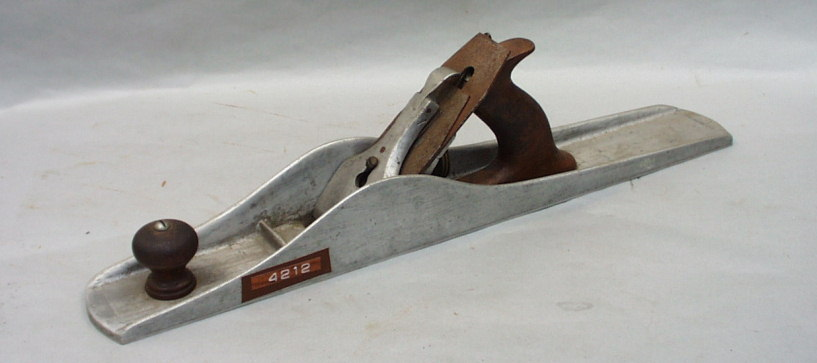

In [5]:
d=next(iter(ds["train"]))
img=d["image"]
img

### 1. Sequential captioning

In [6]:
# Construct a conversation
conversation = [ 
    dict(role="user", 
         content=[
             dict(type="image", image=img),
             dict(type="text", text="Describe the image please"),
         ]) 
]

# Tokenize input
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device, dtype=dtype)

# Query model
output_ids = model.generate(**inputs, max_new_tokens=128)

# Remove input tokens from response
output_ids = output_ids[:, inputs["input_ids"].size(1):]

# Decode tokens to text
outputs = processor.batch_decode(output_ids, skip_special_tokens=True)

print(outputs[0].strip())


The image depicts a vintage hand plane, which is a woodworking tool used for shaping wood. The plane is made of metal, specifically aluminum, and has a rectangular shape with a slightly curved body. The blade of the plane is visible and appears to be made of a dark, possibly steel material. The blade is held in place by a metal lever, which is located on the right side of the plane. This lever is used to adjust the depth of the cut.

The plane has a wooden handle, which is attached to the right side of the plane. The handle is dark brown and appears to be made of a material like mah


### 1b. Sequential captioning: improved prompt
* Short caption
* Provide class label in prompt

In [7]:
prompt = """The image shows a hand plane. Please come up with a short image caption, list and describe the main objects shown in the image. Keep the caption short, one sentence only."""

conversation = [ 
    dict(role="user", 
         content=[
             dict(type="image", image=img),
             dict(type="text", text=prompt),
         ]) 
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(model.device, dtype=dtype)

output_ids = model.generate(**inputs, max_new_tokens=128)
output_ids = output_ids[:, inputs["input_ids"].size(1):]
outputs = processor.batch_decode(output_ids, skip_special_tokens=True)

print(outputs[0].strip())

A vintage hand plane with a wooden handle and a metal blade, marked with the number 4212.


In [8]:
def caption_smolvlm(img, prompt):
    conversation = [ 
        dict(role="user", 
             content=[dict(type="image", image=img), dict(type="text", text=prompt)]
        ) 
    ]
    
    inputs = processor.apply_chat_template(
        conversation,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device, dtype=dtype)
    
    output_ids = model.generate(**inputs, max_new_tokens=128)
    output_ids = output_ids[:, inputs["input_ids"].size(1):]
    outputs = processor.batch_decode(output_ids, skip_special_tokens=True)
    
    return outputs[0].strip()

In [9]:
from torchvision import transforms as T
from tqdm import tqdm
import time

prompt_template = """The image shows a {class_name}. Please come up 
with a short image caption, list and describe the main objects shown 
in the image. Keep the caption short, one sentence only."""

time_start = time.time()
gpu_time = 0
samples = 0 

for i,d in tqdm(enumerate(ds["train"])):
    # 1) resize image to save VRAM
    # 2) extract classname. d["label"] is a number (e.g. 23)  -> string ('vulture')
    image = T.CenterCrop(256)(T.Resize(256)(d["image"]))
    class_name = in_labels[d["label"]]

    # insert class name into prompt
    prompt = prompt_template.format(class_name=class_name)

    # query model
    gpu_start = time.time()
    caption = caption_smolvlm(image, prompt)
    gpu_time += time.time() - gpu_start

    samples += 1
    if i == 200: break

time_total = time.time()-time_start
print(f"samples per second: {samples/time_total:.2f}")
print(f"total time {time_total:.2f} seconds, GPU time: {gpu_time:.2f} seconds, GPU time {gpu_time/time_total*100:.2f}%")

200it [04:33,  1.37s/it]

samples per second: 0.74
total time 273.28 seconds, GPU time: 269.65 seconds, GPU time 98.67%


### 2. Batch captioning
* pass multiple conversations to `SmolVLM2`
* use a `DataLoader` to prefetch and preprocess images 

In [10]:
def batch_caption_smolvlm2(images, prompts):
    conversations = [ 
        [dict(role="user", content=[dict(type="image", image=img),dict(type="text", text=prompt)])]
        for img, prompt in zip(images, prompts)
    ]
    inputs = processor.apply_chat_template(
        conversations,
        add_generation_prompt=True,
        padding=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device, dtype=torch.bfloat16)
    
    output_ids = model.generate(**inputs, max_new_tokens=128)
    output_ids=[ tok_out[len(tok_in):] for tok_in, tok_out in zip(inputs["input_ids"], output_ids) ]     
    generated_texts = processor.batch_decode(output_ids, skip_special_tokens=True)
    
    return [t.strip() for t in generated_texts]

In [11]:
import os, time

processor.tokenizer.padding_side="left"     
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [12]:
from torchvision import transforms as T
from tqdm import tqdm
import time
from torch.utils.data import DataLoader

def collate_fn(items):
    return [
        [T.CenterCrop(256)(T.Resize(256)(i["image"])) for i in items],
        [in_labels[i["label"]] for i in items],
    ]
    
batch_size = 8
dataloader = DataLoader(
    ds["train"], 
    shuffle=False, 
    collate_fn=collate_fn, 
    batch_size=8,     # 8 samples per batch, maximum which fits on a 24GB VRAM GPU 
    num_workers=2,    # Use 2 threads for prefetching
    prefetch_factor=10  # Each thread will prefetch 10 samples
)

prompt_template = """The image shows a {class_name}. Please come up 
with a short image caption, list and describe the main objects shown 
in the image. Keep the caption short, one sentence only."""

time_start = time.time()
gpu_time = 0
samples = 0 

for images, class_names in tqdm(dataloader):
    prompts = [
        prompt_template.format(class_name=class_names[i])
        for i in range(len(images))
    ]
    gpu_start = time.time()
    captions = batch_caption_smolvlm2(images, prompts)
    gpu_time += time.time() - gpu_start
    for c in captions:
        print(c)
    samples += len(images)
    if samples > 200: break

time_total = time.time()-time_start
print(f"samples per second: {samples/time_total:.2f}")
print(f"total time {time_total:.2f} seconds, GPU time: {gpu_time:.2f} seconds, GPU time {gpu_time/time_total*100:.2f}%")

1it [00:07,  7.96s/it]

A hand plane with a wooden handle and a metal body.
Four comic books with titles such as "Punisher War Journal" and "House of Mystery".
A junco bird with brown and gray feathers is standing on a rocky ground.
A zucchini plant with a purple cup on top of it.
A stingray is swimming in shallow water.
A scuba diver is swimming in the ocean.
A woman wearing a brown skirt and a brown sweater is standing in a kitchen.
A black grand piano with a gold frame and a mirror above it.


2it [00:14,  7.31s/it]

A young boy wearing a green shirt is holding a cello.
A Crock Pot with a glass lid and a digital display is sitting on top of a box.
A person is sailing a red and white trimaran on a lake.
Indian cobra with its hood spread open.
A microphone is on top of a speaker.
A yellow car is on top of a pole.
A retro styled cassette player with a handle on top.
A large grey aircraft carrier is sailing on the ocean.


3it [00:21,  7.07s/it]

A young boy is doing a split on parallel bars.
A syringe with a black apple in the background.
A trilobite fossil with a purple and black color.
A man wearing a hat is playing a steel drum.
A person wearing blue sneakers is sitting in a golf cart.
A Windsor tie with a pattern of stripes in gold, black, and white.
A man in a white shirt and blue shorts is playing tennis.
A brown and white Cocker Spaniel dog is sleeping on a leopard print blanket.


4it [00:28,  6.97s/it]

A pufferfish with a honeycomb pattern on its body is on the sand.
A Chesapeake Bay Retriever is standing on a concrete block in a yard.
A bird with blue and grey feathers is perched on a tree branch.
A leatherback sea turtle is laying on the beach.
A husky dog with blue eyes and a pink harness is standing in a field.
A large collection of various types of radiators are displayed in a warehouse.
A Bullmastiff dog is standing in the water on a beach.
A close-up of a tile roof with a green plant growing on it.


5it [00:35,  6.90s/it]

A Cairn Terrier sitting on a wooden floor with its tongue out.
A brown and black Airedale Terrier dog wearing a black collar.
A tiger sits on a chain link fence.
A tape player with knobs and buttons for volume and other controls.
A white sea anemone with long white tentacles on a brown seabed.
A group of baboons are walking in a field.
A woman is sitting in a rocking chair and reading a book.
A can opener is being used to open a can of food.


6it [00:41,  6.86s/it]

A dowitcher is flying over a body of water.
A folded bath towel with pink and white stripes and a pink floral design.
A man wearing a camouflage jacket and a baseball cap is holding a fish.
A rotisserie with chicken and vegetables cooking on it.
A person is being wheeled on a stretcher in a hospital.
A white Kuvasz dog is lying on the ground.
A blue lacewing is perched on a green plant.
A man and a woman are playing slot machines in a casino.


7it [00:48,  6.80s/it]

A sign that says Shoot Dam Here Only is hanging over a dam.
A woman in a swimsuit with a logo on it.
A white oil filter with red and white text on it.
Two geese are standing on the grass near a body of water.
Three white storks standing on a nest on top of a building.
A tarantula is resting on a bed of wood shavings.
A woman is lying on a couch with her legs up in the air.
A coffee machine with a cup on top of it.


8it [00:55,  6.82s/it]

A black and brown Airedale Terrier dog with a collar is looking at the camera.
A scuba diver wearing a yellow and black helmet and a red life jacket is in the water.
A bolete mushroom with a red cap and white gills is growing in the forest.
A blonde woman wearing a black t-shirt with the words "We Love" on it.
A coral fungus is growing in the forest.
A blue crane with the name "Northwest Crane" on it.
A Volvo tape player with a black air vent below it.
A chiton with red and brown spots on its shell.


9it [01:02,  6.82s/it]

A close up of an American bullfrog with a white arrow pointing to its eye.
Three saw blades are on a table in a sawmill.
A collection of wine bottles on a shelf with a green bottle.
A valley with a river and mountains in the background.
A long pier extending into the ocean with a clear blue sky above.
A Pekingese dog is sitting on the ground next to some flowers.
A yawl is sailing on the water with a few people on the beach.
A cheetah is sitting in a grassy field.


10it [01:09,  6.82s/it]

A group of killer whales are swimming in the ocean near a house.
A child in blue pajamas with cars on them is standing in a living room.
A cheeseburger with cheese on top of it.
A bee with yellow pollen on its body is on a leaf.
A sloth bear is walking on a rock near a pond.
A pirate ship with a green and gold color scheme is sailing on the water.
A mink is sitting on a branch.
A Geoffroy's spider monkey is eating a fruit in a forest.


11it [01:15,  6.82s/it]

A close up of an ostrich's head.
A menu with a wooden background and a bottle of hot sauce.
A flamingo with a red head and pink feathers.
A large brown and tan sea turtle is resting on a white cloth.
A doll with blonde hair and a blue dress is sitting on a table.
A row of piggy banks with blue eyes and red ears are lined up on a shelf.
A silver milk can with two handles and a lid.
A baby in a grey onesie is holding a white mop.


12it [01:22,  6.85s/it]

A milk can with the letters D.C.C. on the lid is sitting on the ground.
A toy vacuum cleaner with a hose and a red and blue toy.
A group of Leonbergers are standing in front of a fence.
A stethoscope, a blood pressure cuff, and a box of medical supplies.
A person is using a Panasonic vacuum cleaner to clean the floor.
A white Labrador Retriever is lying on the grass.
A close up of a typewriter keyboard with keys and a logo.
A trifle with strawberries, blackberries and cream in a glass bowl.


13it [01:29,  6.84s/it]

A ruddy turnstone is standing on a pile of rocks.
A Standard Schnauzer dog with a purple leash.
A brown Doberman dog is sitting on a blanket.
A black beetle is on the ground next to some grass.
A red electric locomotive with yellow cargo is pulling a long line of freight cars down a track.
Three spring rolls on a black plate with a spaghetti squash in the background.
Brittany Spaniel standing on a grey background.
A thatched roof house with a stone wall in front of it.


14it [01:36,  6.83s/it]

A black dog is sitting on the snow with a leash on.
A green knitted sweater hanging on a wooden hanger.
A yellow moving truck is parked in front of a building.
A small alligator lizard with a blue and orange striped body is walking on the ground.
Two people are driving go-karts on a track with tires around them.
A pot pie with vegetables and chicken in a white bowl.
A close up of a guenon's face.
A common redshank is walking in the water.


15it [01:43,  6.77s/it]

A black and white soccer ball with a logo on it.
A spotted salamander is on a rock.
A wallaby is eating from a person's hand.
A rattlesnake is on the ground with a dead frog.
A green grasshopper is on a white surface.
A baseball is on a wooden bat.
A green acorn squash is nestled in the dirt.
A close up of an orange in a bowl.


16it [01:49,  6.76s/it]

Three cranes flying in the sky.
A red admiral butterfly is flying in front of a plant.
A painting of a bird is on a table in a room with a shoji.
A cicada is on the ground with its wings spread.
A bottle of Nivea Sun lotion is on the ground in the desert.
A red fox is standing in a field of green plants.
A comic book with a man in a spider suit standing in front of a window.
A tripod is standing on a sidewalk next to a white fence.


17it [01:57,  6.89s/it]

Two men are riding a horse-drawn cart filled with wood.
A man blowing bubbles in a park with a group of people.
A cello is on a stand in a room.
A person is holding a white coffee mug with the words "the coffee mug" on it.
A white church with a dome and crosses on top.
Two motorcyclists wearing helmets are riding on a street with a store in the background.
A woman wearing a pink bra with a necklace.
A blue folding chair with a blue cushion on top of it.


18it [02:04,  7.03s/it]

A close up of a black and white Alaskan Malamute laying down.
Two dogs sitting on the floor, one is a white and brown dog, the other is a black and white dog.
A white Lakeland Terrier stands on a tiled floor.
A hand-held computer with a screen and buttons.
A common redshank is walking on the beach.
A person is holding a dog's nose with a red elf hat on.
A box of Chico brand baby nipple.
A lifeboat with the name Robert Charles Brown on it.


19it [02:11,  7.08s/it]

A yellow spaghetti squash on a beige surface.
Three ostriches with their beaks open are standing in a fenced area.
A green and white tram with the number 323 on the front is driving down a street.
A stone viaduct with arches over a river.
A green Heineken bottle is in the middle of a table with two salt shakers.
A screwdriver set with a yellow and black case.
A CRT monitor with a computer screen on it.
A young woman is sitting on a bench in front of a grand piano.


20it [02:18,  7.06s/it]

A dingo is walking on a grassy field.
Four goblets with red tulip designs on them.
A red shoe with Chinese characters on it is on a table.
A black Sony tape player is sitting on a white plastic basket.
A longhorn beetle with a black and brown body is on the ground.
A group of people pose for a picture in front of a snowmobile.
A red starfish with white spots on its body is on the ocean floor.
A obelisk is in the background of a busy street.


21it [02:26,  7.16s/it]

A pink plectrum is placed on a green surface.
A dhole is walking on a dirt ground.
A large white and brown albatross is swimming in the ocean.
A black French Bulldog is sleeping on the floor with its belly up.
A hand is holding a remote control with six buttons.
Two dogs standing on a wooden deck in front of a house.
A brown butterfly with orange eyes is perched on a white flower.
A black and white Cardigan Welsh Corgi is standing on a grassy field with a yellow and blue tent behind it.


22it [02:33,  7.15s/it]

A ruddy turnstone is walking on the beach.
A pig's head is shown with a metal rod in it.
A prayer rug with blue and gold patterns on a carpeted floor.
A Pembroke Welsh Corgi is lying on the ground.
A white Pyrenean Mountain Dog is sitting outside.
A St. Bernard dog with brown and white fur is looking to the side.
A black and white image of a nail on a wooden surface.
Gila monster on a concrete floor with John H. Tashjian/Fot.


23it [02:40,  7.12s/it]

A blue and white stove with two knobs.
A bullock cart with a man wearing a hat and a cow walking on the road.
A person swimming over a coral reef with fish swimming around.
A group of flamingos standing in a pond.
A black and red bird with a long tail is perched on a leaf.
A pair of black knee pads with the brand name "Fuller" on them.
A ladybug is on a plant with green leaves.
A skunk is sitting in a trash can.


24it [02:47,  7.11s/it]

A Standard Poodle with a red collar and a yellow tag is standing in a room.
A fountain with water flowing from a spout.
A woman wearing a gold trench coat with a belt.
A brown bow with gold accents is on a white background.
A woman in an orange jacket is holding a chainsaw.
A slice of pie with a dollop of cream on a white plate.
A Komodo dragon is resting on a rock.
A hot air balloon is in the sky at sunset.


25it [02:54,  7.15s/it]

A woman in a kimono is standing in front of a crowd.
A glass goblet with a silver base is on display in a glass case.
A bee eater perched on a tree branch.
A longhorn beetle with black and white stripes on its body is sitting on a green leaf.
A leaf beetle with a red and brown body and white spots on its back is sitting on a green leaf.
A sliding door with a sign on it and a reflection of a building in the glass.
A badger is standing on a tiled surface.
Two Kuvasz dogs are playing on the grass.


25it [03:01,  7.27s/it]

A man is standing on top of a military vehicle.
A woman wearing a kimono with a white collar and a black and white pattern.
A metal whistle with a hole in it.
A bobsleigh with two people in it is going down a snowy hill.
A close up of a king penguin with a yellow and white neck.
A black rotary dial telephone with a coiled cord.
Three brown mushrooms with a rough texture are growing on the ground.
A large altar with a statue of Jesus and two smaller statues.
samples per second: 1.14
total time 181.76 seconds, GPU time: 180.63 seconds, GPU time 99.37%


## 3. Other VLMs Sequential

In [1]:
import requests, json
from datasets import load_dataset

def load_imagenet_labels():
    raw_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    response = requests.get(raw_url)
    imagenet_labels = json.loads(response.text)
    return imagenet_labels

ds = load_dataset("ILSVRC/imagenet-1k", streaming=True, trust_remote_code=True)
in_labels = load_imagenet_labels()

In [2]:
from utils_captioning import caption_moondream, caption_qwenvlm, caption_smolvlm

### Moondream

In [3]:
from torchvision import transforms as T
from tqdm import tqdm
import time

prompt_template = """The image shows a {class_name}. Please come up 
with a short image caption, list and describe the main objects shown 
in the image. Keep the caption short, one sentence only."""

time_start = time.time()
gpu_time = 0
samples = 0 

for i,d in tqdm(enumerate(ds["train"])):
    # 1) resize image to save VRAM
    # 2) extract classname. d["label"] is a number (e.g. 23)  -> string ('vulture')
    image = T.CenterCrop(256)(T.Resize(256)(d["image"]))
    class_name = in_labels[d["label"]]

    # insert class name into prompt
    prompt = prompt_template.format(class_name=class_name)

    # query model
    gpu_start = time.time()
    caption = caption_moondream(image, prompt)
    gpu_time += time.time() - gpu_start

    samples += 1
    if i == 200: break

time_total = time.time()-time_start
print(f"samples per second: {samples/time_total:.2f}")
print(f"total time {time_total:.2f} seconds, GPU time: {gpu_time:.2f} seconds, GPU time {gpu_time/time_total*100:.2f}%")

200it [03:14,  1.03it/s]

samples per second: 1.04
total time 194.17 seconds, GPU time: 190.19 seconds, GPU time 97.95%


### QWEN

In [4]:
from torchvision import transforms as T
from tqdm import tqdm
import time

prompt_template = """The image shows a {class_name}. Please come up 
with a short image caption, list and describe the main objects shown 
in the image. Keep the caption short, one sentence only."""

time_start = time.time()
gpu_time = 0
samples = 0 

for i,d in tqdm(enumerate(ds["train"])):
    # 1) resize image to save VRAM
    # 2) extract classname. d["label"] is a number (e.g. 23)  -> string ('vulture')
    image = T.CenterCrop(256)(T.Resize(256)(d["image"]))
    class_name = in_labels[d["label"]]

    # insert class name into prompt
    prompt = prompt_template.format(class_name=class_name)

    # query model
    gpu_start = time.time()
    caption = caption_qwenvlm(image, prompt)
    gpu_time += time.time() - gpu_start

    samples += 1
    if i == 200: break

time_total = time.time()-time_start
print(f"samples per second: {samples/time_total:.2f}")
print(f"total time {time_total:.2f} seconds, GPU time: {gpu_time:.2f} seconds, GPU time {gpu_time/time_total*100:.2f}%")

200it [05:25,  1.63s/it]

samples per second: 0.62
total time 325.15 seconds, GPU time: 320.99 seconds, GPU time 98.72%


### 3. Other VLMs Batched

In [1]:
import requests, json
from datasets import load_dataset

def load_imagenet_labels():
    raw_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
    response = requests.get(raw_url)
    imagenet_labels = json.loads(response.text)
    return imagenet_labels

ds = load_dataset("ILSVRC/imagenet-1k", streaming=True, trust_remote_code=True)
in_labels = load_imagenet_labels()

In [2]:
from utils_captioning import batch_caption_smolvlm2, batch_caption_qwenvlm, batch_caption_moondream

### Moondream

In [4]:
from torchvision import transforms as T
from tqdm import tqdm
import time
from torch.utils.data import DataLoader

def collate_fn(items):
    return [
        [T.CenterCrop(256)(T.Resize(256)(i["image"])) for i in items],
        [in_labels[i["label"]] for i in items],
    ]
    
batch_size = 8
dataloader = DataLoader(
    ds["train"], 
    shuffle=False, 
    collate_fn=collate_fn, 
    batch_size=8,     # 8 samples per batch, maximum which fits on a 24GB VRAM GPU 
    num_workers=2,    # Use 2 threads for prefetching
    prefetch_factor=10  # Each thread will prefetch 10 samples
)

prompt_template = """The image shows a {class_name}. Please come up 
with a short image caption, list and describe the main objects shown 
in the image. Keep the caption short, one sentence only."""

time_start = time.time()
gpu_time = 0
samples = 0 

for images, class_names in tqdm(dataloader):
    prompts = [
        prompt_template.format(class_name=class_names[i])
        for i in range(len(images))
    ]
    gpu_start = time.time()
    captions = batch_caption_moondream(images, prompts)
    gpu_time += time.time() - gpu_start
    for c in captions:
        print(c)
    samples += len(images)
    if samples > 200: break

time_total = time.time()-time_start
print(f"samples per second: {samples/time_total:.2f}")
print(f"total time {time_total:.2f} seconds, GPU time: {gpu_time:.2f} seconds, GPU time {gpu_time/time_total*100:.2f}%")

1it [00:13, 13.04s/it]

A hand plane with a wooden handle and metal blade rests on a metal base, labeled "212".
Four comic books are displayed, including "Punisher War Journal", "House of Mystery", "Cable", and "The Author".
A junco bird with a brown and black head and a white breast stands on a bed of gray rocks and twigs.
A zucchini plant with green leaves and a purple plastic container is shown, along with a bag of strawberries.
A stingray is partially submerged in shallow, clear water.
A scuba diver in a black wetsuit and pink fins is seen underwater, with a rocky seabed and a cloudy sky above.
A person wearing a brown sweater and a brown skirt stands in a kitchen, holding a white cup.
A grand piano with a black and gold finish, a white bench, and a decorative clock on the lid.


2it [00:20,  9.70s/it]

A person plays a cello, seated on a chair, with a wooden wall and two onlookers in the background.
A Crock Pot with a glass lid and digital display is shown, resting on a blue box.
A sailboat with a red sail and white hull is sailing on a calm body of water, with a person in a yellow jacket on board.
A cobra with a light brown body and darker brown head and neck, facing the camera.
A microphone on a tripod, with a small device attached to the top.
A yellow go-kart with blue flames and the number 11 is suspended from a pole against a blue sky.
A brown cassette player with a black antenna sits on a pink surface.
A large aircraft carrier sails across the ocean, with a smokestack releasing smoke and a radar tower visible.


3it [00:28,  8.82s/it]

A young child in a red shirt and shorts is performing a gymnastics routine on parallel bars.
A syringe with blue, green, red, and silver liquid is inserted into an apple, with the syringe's tip piercing the apple's skin.
A trilobite fossil, exhibiting a dark purple hue, is displayed against a light gray, textured background.
A man plays a large, black steel drum, surrounded by other percussion instruments and a crowd.
A person's feet are on a golf cart's gas and brake pedals, with a bench and ocean in the background.
A tie with horizontal stripes of varying shades of brown and beige is shown against a light beige background.
A tennis player in white and blue is hitting a yellow ball with a racket.
Two Cocker Spaniels rest on a leopard print blanket, one lying down and the other partially obscured.


4it [00:36,  8.43s/it]

A pufferfish lies on a sandy beach, its body covered in a pattern of hexagonal scales.
A dog with a frisbee in its mouth stands on a concrete ledge, with a person holding a blue frisbee in the background.
A bird of prey, possibly a hawk or falcon, perched on a weathered log in a dry field.
A large sea turtle with a dark blue shell and pink underbelly is resting on a sandy beach, with the ocean visible in the background.
A husky with a pink harness and a person's arm holding it is pictured.
A large collection of old, rusted, and weathered radiators are stacked in an outdoor storage area.
A Bullmastiff stands in shallow water, facing right, with another dog visible in the background.
A tiled roof with a curved edge and a small plant growing in the crevices.


5it [00:43,  8.15s/it]

A small, light brown Cairn Terrier sits on a wooden floor, tongue out, with a bookshelf and black and white checkered floor in the background.
Airedale Terrier with a black collar and a brown and black coat.
A tiger sits on a tree branch, facing right, with a chain link fence and rocks in the background.
A silver tape player with knobs for volume, time, and channel selection is shown.
A white sea anemone with long, thin tentacles is the central focus, surrounded by other marine life and coral.
A group of baboons are gathered in a grassy area, with some standing and others sitting.
A woman sits in a light green rocking chair, reading a magazine, with a stack of books and a vase nearby.
A hand uses a white can opener to open a can of green beans.


6it [00:51,  7.90s/it]

Two birds are seen near the water's edge, with tall grasses and a grassy bank in the background.
Two white bath towels with pink floral embroidery are folded and placed on a wooden surface, accompanied by a small branch with red berries.
A man in camouflage holds a tench fish in a dark, wooded setting.
Chicken, vegetables, and bread are being cooked on a rotisserie.
A patient is being moved on a stretcher, assisted by medical personnel.
A white dog with curly fur is lying on a concrete surface, with a dark object partially visible in the background.
A lacewing with translucent wings and a dark head is perched on a green plant with a white flower.
A woman sits at a slot machine, while a man stands nearby, with additional slot machines and a bar in the background.


7it [00:59,  7.98s/it]

A concrete dam with a metal railing, a yellow sign warning of the danger, and a small waterfall.
A woman wearing a dark tank top with a logo on the side, posing against a building.
A white oil filter with red and white branding is shown against a blue background.
Two Canadian geese stand on a grassy bank near a body of water, one facing the camera and the other facing away.
Three storks are perched on a weathered stone structure, with one stork facing the camera and two others turned away.
A large tarantula with long legs and a brown body is shown in a dark, rocky enclosure.
A woman lies on a couch with her legs up, wearing a striped shirt and dark leggings, with a white pillow and a dark bag nearby.
A silver Rancilio espresso machine with a coffee cup on top, a bottle of honey, and a coffee grinder are shown.


8it [01:06,  7.72s/it]

Airedale Terrier with black and tan fur, orange eyes, and a black collar.
A diver wearing a yellow and black helmet and oxygen tank is shown in the water.
A bolete mushroom with a brown cap and green stem is shown in the image.
A woman with blonde hair wears a black t-shirt with the phrase "WE LOVE" in pink and white, standing against a red brick wall.
A coral fungus with orange and white stripes is shown in the image, surrounded by green leaves and brown dirt.
A blue truck with a crane, displaying contact information, is parked on a gravel surface.
A Volvo CD player with a cassette tape is shown.
Several chitons with reddish markings are clustered together on a light-colored rock surface, with small rocks and debris scattered around.


9it [01:13,  7.46s/it]

A green American bullfrog with a white eye is shown, resting on a sandy surface.
Two large saw blades and a smaller one are stacked in a sawmill.
A collection of wine bottles, varying in size, shape, and color, are displayed on a wooden shelf.
A valley with a large rock formation, a river, and a bridge is shown.
A wooden pier extends into a calm ocean, with a chain-link fence on the left and a sandy beach on the right.
A Pekingese dog sits on the ground, surrounded by pink flowers and green leaves.
A yawl is a small sailboat with a single mast, anchored in the harbor.
A cheetah sits in a grassy field, facing the camera with a focused gaze.


10it [01:20,  7.49s/it]

Three orcas swim in a body of water, with a small boat and a dock visible in the background.
A child in blue pajamas, holding a toy car, stands near a yellow book and a wooden table.
A cheeseburger is being cooked in a frying pan, with melted cheese and a patty.
A bee with yellow and black stripes sits on a green leaf, facing the camera.
A sloth bear stands on a rock near a body of water, with its head lowered and eyes open.
A large, colorful pirate ship with multiple masts and flags sails on a body of water, with people on the deck and a backdrop of hills and buildings.
A porcupine, with its distinctive spines, is perched on a branch.
A Geoffroy's spider monkey holds a red fruit in its hand, surrounded by green foliage.


11it [01:28,  7.56s/it]

Close-up of an ostrich's head and neck, with a dark background.
A menu featuring appetizers, sauces, salads, fries, and wings, with a chili pepper and hot sauce bottle as decorative elements.
A close-up image of a flamingo's head and neck, showcasing its vibrant pink and orange plumage and striking green eye.
A sea turtle with a brown shell and white spots rests on a floral-patterned mat.
A doll with blonde hair and a blue and white dress sits next to a white teacup and saucer with pink and green floral accents.
Several gold piggy banks with red accents are displayed on a shelf, with one slightly ahead of the others.
A silver milk can with two handles and a lid is shown against a plain background.
A young child holds a mop, standing on a wooden floor in a living room.


12it [01:36,  7.60s/it]

A silver milk can with a handle and lid, labeled "D.C.C."
A blue and red toy vacuum cleaner with a black hose and a red and white cleaning pad are shown.
A Leonberger lies on the ground, partially covered in snow, with a group of puppies interacting with it.
A stethoscope, with a black chest piece, silver earpieces, and a black diaphragm, is shown alongside its accompanying black pouch and green box.
A person is using a Panasonic vacuum cleaner to clean a light-colored carpet.
A white Labrador Retriever puppy lies on a green lawn, wearing a collar with a pattern.
A close-up view of an old typewriter keyboard, featuring a worn surface, keys, and a visible 'SP' logo.
A round dessert dish with a creamy white filling, sliced strawberries, and blackberries arranged in a flower pattern.


13it [01:43,  7.57s/it]

A ruddy turnstone stands on a pile of seaweed, facing left.
A Standard Schnauzer with a purple collar and white markings on its head and muzzle is shown, possibly at a dog show.
A brown Doberman Pinscher dog with a red collar and tag sits on a dog bed, looking at the camera.
A leaf beetle with black body and legs is shown in a close-up view, with a grassy background.
A red electric locomotive pulls a long line of yellow freight cars along a railway track, with power lines overhead and a building in the background.
Three rice paper wraps filled with a yellow sauce and green vegetables are arranged on a black plate.
A Brittany Spaniel stands on a gray background, facing right.
A thatched roof cottage with a white wall, stone wall, and hanging flower baskets is pictured.


14it [01:50,  7.46s/it]

A black dog sits on a snowy hill, tethered by a leash, with a person in the background.
A green knitted cardigan with a v-neck and buttons is displayed on a wooden hanger against a white background.
A yellow delivery truck and a yellow taxi are parked in a garage.
A brown and orange striped lizard is seen in a rocky area, with a large rock partially obscuring it.
Two people are driving go-karts on a paved track, surrounded by tires and a fence.
A pot pie with chicken, cauliflower, and broccoli in a creamy sauce.
A guenon is shown in a close-up view, with its head and neck visible, against a blurred background of green foliage.
A bird wading in shallow water, with a blurred background of green vegetation.


15it [01:57,  7.32s/it]

A worn soccer ball with a black and white pattern rests on the grass, accompanied by a partially visible can.
A spotted salamander with dark brown body and yellow spots is shown on a reddish-brown surface.
A wallaby eats from a person's hand, with a pile of pellets nearby.
A rattlesnake is curled up on the ground, with its head and tail visible.
A green grasshopper with red eyes and antennae is shown on a leaf.
A baseball bat and ball are shown in the image.
A dark green acorn squash with a textured surface is shown in a garden setting, surrounded by green leaves and stems.
A close-up image shows a bright orange, a red apple, and a partially visible green apple in a bowl.


16it [02:05,  7.54s/it]

Three cranes fly in a diagonal line against a light blue sky.
A red and black butterfly with orange spots is shown against a light blue background, with a shadow of a plant on the left.
A shoji is a traditional Japanese sliding door, displayed in a room with wooden furniture and a wooden shelf.
A cicada with a yellow and black striped head and a black and yellow striped thorax is shown on a light gray gravel surface.
A blue bottle of Nivea sunscreen with a white cap and orange label is shown on a sandy beach, with mountains in the background.
A red fox stands amidst green foliage, its reddish-brown fur contrasting with the surrounding vegetation.
A comic book cover features Spiderman with his hand over his face, a smaller figure in a blue suit, and a cityscape in the background.
A black tripod stands on a sidewalk, with a white fence and house in the background.


17it [02:13,  7.65s/it]

Two men ride a horse-drawn cart carrying a large load of firewood, with a brick building and signs in the background.
A young man blows bubbles in a park, surrounded by other people and trees.
A person playing a cello, with sheet music in front of them, in a dimly lit room.
A hand holds a coffee mug with a logo, set against a blurred natural background.
A white domed church with a cross, bell tower, and arched windows is shown against a blue sky.
Two scooters, one white and one yellow, are parked on a city street, with a person on each, and a crowd of people in the background.
A woman with long brown hair, wearing a beige off-the-shoulder sweater and pink bra straps, stands against a white background.
A folding chair with a teal cushion and dark metal frame is shown against a plain wall.


18it [02:21,  7.69s/it]

A black and white dog with a red collar lies on the grass, looking at the camera.
Two dogs, one white with black spots and one brown and white, are standing on a carpeted floor in front of a wooden entertainment center.
A white dog with black spots, standing on a tiled floor, with a potted plant and a wooden surface nearby.
A gray handheld device with a screen displaying text and buttons, and a black handle.
A redshank wades in shallow water along a sandy beach, with small rocks and pebbles scattered around.
A Wire Fox Terrier is being fed by a person wearing a Santa hat.
Two baby bottles with silicone nipples, labeled "Fisiologica", are shown in the image.
A lifeboat with the name "Robert Charles Brown" and "RNLB" is displayed in a museum, accompanied by a wooden railing and a plaque.


19it [02:29,  7.61s/it]

A whole spaghetti squash and a slice are shown on a beige surface.
Four ostriches stand in a fenced enclosure, with one facing the camera and the others turned away.
A green tram with a gold roof and the number 323 is shown, with people inside and flags on top.
A stone viaduct with arched openings spans a river, with a bridge and trees in the background.
A salt shaker, a bottle of Heineken beer, and a glass jar of pepper are visible on a wooden table.
A black toolbox with a yellow handle contains a set of screwdrivers and other tools, labeled "tools that work".
Two computer monitors, one CRT and one flat screen, are connected to a cable.
A young woman sits on a black piano bench, smiling at the camera, with a grand piano in the background.


20it [02:37,  7.80s/it]

A dingo with reddish-brown fur and white markings is running through a grassy field.
Four goblets with red flower designs and green stems are arranged in a row.
A stall displays a variety of colorful clogs, including red, orange, yellow, purple, and green, arranged on shelves and hanging from the ceiling.
A Sony portable cassette player with a black handle and speaker sits on a white plastic laundry basket.
A close-up image of a longhorn beetle, showcasing its dark brown body, light brown head, and prominent antennae.
A blue snowmobile with the words "Touring" and "Touring" on the side, and an American flag, is parked in a snowy area with a group of people.
A red starfish with white spots is shown in the image.
A tall obelisk stands in a city square, with cars and a truck parked nearby, and a construction site in the background.


21it [02:44,  7.64s/it]

A pink plectrum rests on a sandy surface, with a darker, possibly fabric, background.
A reddish-brown dhole with white markings walks on a dirt path, its shadow cast on the ground.
A large bird with a white head and brown wing is swimming in blue water.
A black French Bulldog lies on its back on a beige carpet, wearing a green collar.
A hand holds a silver remote control with black buttons, with a blurred background of a laptop and a blue light.
Two dogs, one brown and one black, stand on a wooden deck in front of a house.
A brown butterfly with white stripes rests on a white flower with a yellow center.
A Cardigan Welsh Corgi is running through a yellow obstacle course, with a red fence and orange cones in the background.


22it [02:51,  7.50s/it]

Two ruddy turnstones, one in the foreground and one in the background, are shown on a beach covered in seashells.
A pig's body, including internal organs, is shown.
A prayer rug with a repeating diamond pattern and white fringe is displayed on a light blue floor.
A Pembroke Welsh Corgi lies on a rocky surface, looking directly at the camera.
A Pyrenean Mountain Dog with a black nose and eyes, looking to the left, with a dirt path and fence in the background.
A St. Bernard dog with a white and brown coat is shown against a gray background.
A close-up view of a wooden plank with a nail embedded in it, and a blurred background.
A Gila monster with brown and white spotted skin is shown on a light brown surface.


23it [02:57,  7.01s/it]

A white stove with two knobs and a wire rack is shown.
A bullock cart with a decorated wheel and two white cows is shown.
A person snorkeling above a vibrant coral reef, with small fish swimming around.
Four flamingos stand on a patch of dirt in a lush, green enclosure.
A coucal, a black and orange bird, perches on a green leaf.
Two black knee pads with red branding are shown.
A ladybug with black spots on an orange body is perched on a green stem with white speckles.
A skunk is sitting in a trash can, surrounded by various discarded items.


24it [03:04,  6.92s/it]

A Standard Poodle stands on a carpeted floor, wearing a red collar with a yellow tag, in front of a wooden bookshelf.
A stone fountain with a central spout and water jets is shown, with a blurred background of green foliage.
A woman wearing a gold trench coat stands against a gray backdrop.
A brown bow with a gold loop and a black string are shown.
A person holds a gorilla puppet with a chainsaw, while another person observes in the background.
A slice of pie with a golden crust and a dollop of whipped cream on a white plate.
A Komodo dragon rests on a tree trunk in a rocky enclosure.
Several hot air balloons are visible against a sunset sky, with one large balloon prominently featured in the foreground.


25it [03:11,  7.07s/it]

A woman in a black kimono with gold accents and a gold headpiece holds a red and gold cloth, surrounded by other individuals in similar attire.
A goblet with a silver base and leaf design sits on a glass shelf, with other glassware visible in the background.
A bee eater with a yellow and green body and a long, thin beak is perched on a branch, facing right.
A black and white longhorn beetle with long antennae is shown on a green leaf.
A reddish-brown beetle with white spots rests on a green leaf.
A sliding glass door with a sign and two doors with signs is shown.
A badger stands on a concrete surface, facing the camera, with a grassy area in the background.
Two white puppies, possibly Kuvasz, playfully nuzzle each other in a grassy area.


25it [03:19,  7.98s/it]

A military vehicle with a star on its side and a man standing on top is parked on a dirt road.
A woman in a traditional Japanese kimono, with a black and white pattern, stands against a dark wooden background.
A metal object with a hole and a handle, possibly a tool or part of a device.
A bobsleigh with the number 2 and sponsor logos is in motion on a snowy track, with a person in a helmet and red jacket.
A king penguin with a black and yellow head and white chest is shown, with its beak slightly open.
A black rotary dial telephone with a coiled cord is shown against a white background.
Three large, reddish-brown mushrooms with white caps are shown growing on a mossy surface.
A large ornate altar with a crucifix, statues, and a central image is shown in a church interior.
samples per second: 1.04
total time 199.41 seconds, GPU time: 198.10 seconds, GPU time 99.34%


In [3]:
from torchvision import transforms as T
from tqdm import tqdm
import time
from torch.utils.data import DataLoader

def collate_fn(items):
    return [
        [T.CenterCrop(256)(T.Resize(256)(i["image"])) for i in items],
        [in_labels[i["label"]] for i in items],
    ]
    
batch_size = 8
dataloader = DataLoader(
    ds["train"], 
    shuffle=False, 
    collate_fn=collate_fn, 
    batch_size=8,     # 8 samples per batch, maximum which fits on a 24GB VRAM GPU 
    num_workers=2,    # Use 2 threads for prefetching
    prefetch_factor=10  # Each thread will prefetch 10 samples
)

prompt_template = """The image shows a {class_name}. Please come up 
with a short image caption, list and describe the main objects shown 
in the image. Keep the caption short, one sentence only."""

time_start = time.time()
gpu_time = 0
samples = 0 

for images, class_names in tqdm(dataloader):
    prompts = [
        prompt_template.format(class_name=class_names[i])
        for i in range(len(images))
    ]
    gpu_start = time.time()
    captions = batch_caption_qwenvlm(images, prompts)
    gpu_time += time.time() - gpu_start
    for c in captions:
        print(c)
    samples += len(images)
    if samples > 200: break

time_total = time.time()-time_start
print(f"samples per second: {samples/time_total:.2f}")
print(f"total time {time_total:.2f} seconds, GPU time: {gpu_time:.2f} seconds, GPU time {gpu_time/time_total*100:.2f}%")

0it [00:00, ?it/s]Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

1it [00:13, 13.85s/it]

A vintage hand plane with a wooden handle and metal blade, marked "4212."
"Marvel Comics featuring 'The Punisher War Journal' and 'Cable' alongside 'Houses of Mystery'."
A small bird with brown and white plumage stands on rocky ground.
"Zucchini growing on a green plant with purple flower pots."
A stingray swims gracefully in shallow water near the shore.
A scuba diver swims near a rocky underwater formation.
Caption: "A person wearing a mustard yellow sweater and brown skirt in a kitchen."

Main Objects:
1. Miniskirt - Brown color.
2. Sweater - Mustard yellow color.
3. Kitchen setting - Includes cabinets, drawers, and various items on countertops.
4. Person - Partially visible, wearing the mentioned clothing.
A black grand piano with a matching bench in a cozy living room setting.


2it [00:15,  6.89s/it]

A child in a green sweater and purple pants is playing a cello.
Crock Pot with digital display and control panel.
A trimaran with a red sail is sailing on calm waters at sunset.
"An Indian cobra with its hood expanded, showcasing its striking pattern."
A vintage microphone mounted on a stand with a cable, set against a plain background.
A yellow airplane model is mounted on a black pole against a clear blue sky with faint contrails.
A vintage brown cassette player with a tape deck and radio features.
Aircraft carrier sailing on the ocean with waves crashing against its side.


3it [00:22,  6.61s/it]

A young child is sitting on a set of parallel bars.
A syringe with blue, red, and green liquid is injecting into a black apple.
A fossilized trilobite with intricate wing-like structures and a segmented body.
A steel drum is being played by a person wearing a hat and jeans.
Caption: "Golf cart on a sunny day by the beach."

Main Objects:
1. Golf Cart - A small vehicle typically used for transporting golfers to and from the course.
2. Person's Legs - Visible in the foreground, wearing jeans and blue sneakers.
3. Beach - In the background, with sand and water visible.
4. Sky - Clear and bright, indicating a sunny day.
A classic Windsor tie with a striped pattern in shades of brown and beige.
A tennis player in action, swinging his racket at a ball on a green court with the word "Wimbledon" visible in the background.
Caption: "Cuddling Cocker Spaniels snuggle together on a leopard print blanket."

Main Objects:
1. Two Cocker Spaniels - one brown and one light-colored.
2. Leopard print bla

4it [00:24,  4.97s/it]

A pufferfish with a distinctive hexagonal pattern on its body is resting on sandy ground.
A Chesapeake Bay Retriever stands on a grassy patch, with a person holding a blue object in front of it.
A bird perched on a wooden post in a natural setting.
A leatherback sea turtle rests on a sandy beach near the ocean.
A Siberian Husky with striking blue eyes and a red harness is standing in a grassy field.
A collection of old and new radiators is displayed outside a store.
A Bullmastiff stands on a sandy beach with a cloudy sky in the background.
"An aged, weathered tile roof with darkened edges and patches of moss."


5it [00:28,  4.47s/it]

A small, fluffy dog with a long tongue sits on a wooden floor in front of a bookshelf.
Airedale Terrier with a black collar looking to the left.
A majestic tiger sits by a tree, its vibrant stripes contrasting with the natural surroundings.
A vintage tape player with an FM radio tuner and volume control knobs.
A sea anemone with long, white tentacles is attached to a rocky underwater surface.
A group of baboons is gathered in a grassy clearing surrounded by dense green foliage.
A person is sitting in a green rocking chair, reading a book while wearing black pants and a white shirt. The room has a wooden floor, a radiator, and a window with a view of trees outside.
"Effortless Can Opener: A Simple Tool for Opening Cans Easily."


6it [00:30,  3.67s/it]

A dowitcher is captured in flight over a calm water body with reeds in the background.
A soft, cream-colored bath towel with a pink stripe and embroidered design lies neatly folded on a wooden surface.
A man in camouflage clothing holds a large tench fish, showcasing his fishing success.
A rotisserie with skewered meat and vegetables cooking on a grill.
A patient is being transported on a stretcher in a hospital setting.
A Kuvasz dog lying on a wooden deck with leaves scattered around.
A lacewing insect perches on a green stem with white flowers in the background.
A woman is playing a slot machine at a casino.


7it [00:32,  3.13s/it]

A warning sign on a dam reads "DAM SHOOT DAM HERE ONLY."
A woman in a red and white tank suit poses confidently at an event.
"Yanmar Genuine Parts Oil Filter 129150-35152"
Two geese foraging on a grassy shore near a body of water.
Two white storks perched on a chimney nest.
A tarantula with long legs and hairy body is sitting on a dark surface.
A person lying on a couch with their feet in the air, wearing a striped dress and black shoes.
"Espresso machine with a plaid cloth draped over it."


8it [00:40,  4.79s/it]

Airedale Terrier with expressive eyes looking directly at the camera.
Caption: "Diver in full gear prepares for an underwater adventure."

Main Objects:
1. Scuba Diver - Wearing a black helmet with a yellow visor, a red life jacket, and a black wetsuit.
2. Water - The background is a body of water, likely an ocean or sea, with gentle waves.
3. Dive Equipment - Includes a snorkel and a mask, both attached to the diver's face.
4. Dive Gear - The diver is equipped with a black wetsuit and a red life jacket for safety.
A bolete mushroom growing in a forest floor with green leaves and pine needles surrounding it.
A woman wearing a black T-shirt with "We Love" in pink letters stands against a brick wall.
A vibrant coral fungus growing amidst green foliage and fallen leaves in a forest setting.
"Blue crane truck with 'Columbus Crane' branding on the side."
"Vintage Volvo Tape Player with CD Slot and Radio Controls"
A chiton with its shell partially open, revealing its colorful interior.


9it [00:42,  3.95s/it]

A green American bullfrog with a needle piercing its back.
"Old sawmill gears in close-up view."
A collection of wine bottles arranged on a wooden shelf, showcasing various types and brands.
A winding road cuts through a lush green valley with rocky cliffs on either side.
A wooden pier extends into the ocean under a clear blue sky.
A Pekingese puppy stands amidst vibrant pink flowers, showcasing its fluffy fur and curious expression.
A group of sailboats on the water with a person standing on the shore.
A cheetah stands alert in a grassy savannah, its spotted coat blending with the greenery.


10it [00:45,  3.43s/it]

"Three killer whales swimming in the water near a forested shoreline."
A young child in pajamas stands on a carpeted floor next to a wooden table with toys on it.
"Cheese melting on a burger patty in a frying pan."
A bee is perched on a green leaf with a pink flower in the background.
A sloth bear stands on its hind legs, showcasing its distinctive black fur and long claws.
A pirate ship with multiple masts and flags sails on calm waters near a scenic coastal town.
A mink is sitting on a branch in the forest.
Geoffroy's spider monkey hanging from a branch with leaves in the background.


11it [00:47,  3.06s/it]

"Close-up of an ostrich's face against a dark background."
A colorful menu featuring appetizers, sauces, fries, and salads with various prices listed.
A flamingo with vibrant red feathers is resting its head on its wing.
A loggerhead sea turtle rests on a floral-patterned cushion.
A cute character figurine stands next to a white ceramic cup with a matching saucer on a checkered tablecloth.
A group of golden piggy banks lined up on a cardboard box.
A vintage milk can with a shiny metallic finish and two small rivets on its side.
A toddler is holding a mop in a living room.


12it [00:49,  2.88s/it]

A vintage milk can with a metal lid, featuring the initials "D.L.C." on top, is placed on a concrete surface.
A toy vacuum cleaner with a red and blue color scheme is displayed in its packaging.
Leonberger puppies playing in a snowy enclosure.
"Stethoscope with a green box in the background."
A person is using a vintage Panasonic vacuum cleaner on a carpeted floor.
A white Labrador Retriever is lying on green grass with its head tilted to the side.
"An old, vintage typewriter with a worn-out keyboard."
A strawberry and blackberry trifle with a white cream topping.


13it [00:56,  4.16s/it]

A ruddy turnstone stands on a rocky shore, its orange legs and distinctive brown and white plumage clearly visible.

Main Objects:
1. Ruddy Turnstone: A small bird with a distinctive appearance, featuring brown and white feathers.
2. Rocky Shore: The background consists of rocks and possibly seaweed, indicating a coastal environment.
3. Orange Legs: The bird's legs are bright orange, providing a striking contrast to its feathers.
Caption: "Standard Schnauzer at a dog show, showcasing its distinctive features."

Main Objects:
1. **Standard Schnauzer**: The central subject of the image, displaying its characteristic long, shaggy fur and bushy eyebrows.
2. **Leash**: A purple leash attached to the dog's collar, indicating it is being held by someone.
3. **Background**: Blurred, likely indicating the setting is an indoor or controlled environment typical for dog shows.
A Doberman sits on a cushion in front of a stereo system.
Leaf beetle on grass with fallen leaves in background.
A red ele

14it [01:03,  4.79s/it]

Caption: "A Schipperke sits patiently on a snowy hill, while its owner stands nearby."

Main Objects:
1. A black Schipperke dog sitting on the snow.
2. A person standing in the background, partially obscured by the snow.
3. A leash attached to the dog's collar, extending into the frame.
4. A snowy landscape with trees in the distance.
A green knitted cardigan with buttons on a hanger.
A yellow moving van is driving on a road next to a yellow taxi.
A colorful alligator lizard with orange, white, and brown stripes is resting near a rock in a sandy environment.
"Two enthusiastic go-kart racers speeding down the track."
A creamy vegetable and chicken pot pie with a spoon in it.
Caption: "A close-up of a guenon monkey with distinctive black, white, and orange fur."

Main Objects:
1. A guenon monkey - characterized by its unique fur coloration, which includes black, white, and orange patches.
2. The monkey's face and upper body are visible in the image.
3. The background appears to be blurre

15it [01:05,  4.10s/it]

A worn soccer ball with signatures on its surface rests on grass.
A spotted salamander with orange and yellow spots on its body is resting on a reddish-brown surface.
A wallaby is being fed by a person's hand. The wallaby has large ears and a black nose.
Eastern Diamondback Rattlesnake on the ground with its distinctive diamond-shaped head and rattle tail.
A vibrant green grasshopper perches on a frost-covered leaf, its red eyes and antennae standing out against the white frost.
A close-up of a baseball being held by a bat, ready for a swing.
A small, dark green acorn squash growing in a garden bed surrounded by green leaves and vines.
A close-up of an orange with a blurred background featuring apples and other fruits.


16it [01:10,  4.41s/it]

Three sandhill cranes in flight against a clear sky.
A vibrant red admiral butterfly with black, orange, and white markings is perched on a reflective surface, casting a shadow of its wings.
A traditional Japanese room with a shoji screen, a wooden cabinet, and various decorative items on a table.
A cicada with a vibrant orange and black pattern on its wings is perched on a textured surface.
Caption: "Nivea Sunscreen Lotion in a Desert Landscape."

Main Objects:
1. Nivea Sunscreen Lotion - A blue bottle with white cap containing sunscreen.
2. Desert Landscape - Sandy terrain with distant mountains under a yellowish sky.
Caption: "Red fox amidst green foliage."

Main Objects:
1. Red Fox - A small, reddish-brown fox with a bushy tail and pointed ears.
2. Foliage - Green, dense vegetation surrounding the fox.
"Spider-Man in 'Death Without Warning' Issue 1."
A black tripod stands tall against a white fence with a house in the background under a partly cloudy sky.

Main Objects:
1. Tripod -

17it [01:13,  3.87s/it]

A man rides a horse-drawn cart loaded with wood in an urban setting.
A person blowing bubbles in a park with other people in the background.
A musician plays the cello on stage with sheet music in front of him.
A hand holding a white coffee mug with the text "the coffee mug" on it, set against a backdrop of a rustic outdoor scene.
A blue and white church with a dome and bells against a clear sky.
Two motorcyclists on scooters in a city street with flags and shops in the background.
A woman wearing a beige knitted top with a pink bra underneath.
A blue patterned folding chair with a metal frame stands on a wooden floor against a plain wall.


18it [01:20,  4.76s/it]

A Alaskan Malamute lying on grass with a red collar around its neck.
Two dogs, one white with brown spots and the other brown and white, stand side by side in front of a wooden cabinet.
A Lakeland Terrier stands on a tiled floor, surrounded by houseplants.
Caption: "Hand-held computer displaying various settings and options."

Main Objects:
1. Hand-held computer device.
2. Display screen showing text and icons.
3. Several buttons and controls on the front of the device.
4. A small screen or display area at the bottom.
5. Various settings and options listed on the screen.
Caption: "A common redshank stands on a pebbly beach near the water."

Main Objects:
1. Common Redshank - A small wading bird with orange legs, brownish-grey plumage, and a long beak.
2. Beach - A sandy shore with small pebbles and shells.
3. Water - The edge of the water is visible, showing a gradient from blue to grey as it meets the sand.
A Wire Fox Terrier is playing with a small red cone-shaped toy while a child i

19it [01:22,  4.01s/it]

A spaghetti squash with a partially peeled piece on a textured surface.
Three ostriches standing in a fenced area with greenery in the background.
A vintage green tram with the number 323 on its side is traveling down a street lined with buildings and flags.
"Stone arch bridge spanning over a calm river with lush greenery in the background."
A close-up of a salt shaker with a blurred background featuring a green bottle and a glass filled with a creamy beverage.
Tools That Work Screwdriver Set in Black Case
Two CRT monitors displaying different content on a desk.
A young woman sits on a black leather stool in front of a polished grand piano, smiling at the camera.


20it [01:27,  4.41s/it]

A dingo stands alert on a grassy field, its reddish-brown fur contrasting with the greenery around it.

Main Objects:
1. Dingo: A wild dog with reddish-brown fur.
2. Grass: The ground covered in green grass.
3. Field: The open area where the dingo is standing.
Goblets with red tulip designs on them.
A vibrant display of colorful clogs in various sizes and designs.
A vintage tape player sits atop a white laundry basket.
A close-up of a longhorn beetle with a dark body and light stripes on its thorax.
A group of people posing with a snowmobile branded "Snowmobile Touring 2005".
A vibrant red starfish with white spots on a greenish background.
A tall obelisk stands prominently in the background, with cars and buses moving along a road in front of it.


21it [01:30,  3.84s/it]

A pink plectrum lies on a textured surface, possibly sand or fabric.
A dhole stands on a dirt path, surrounded by shadows from trees.
A majestic albatross gracefully swims in the vast ocean, its wings spread wide against the backdrop of deep blue waters.
A French Bulldog wearing a green collar is lying on its back on a beige carpet with a red patterned blanket in the background.
A hand holding a remote control with a blurred background featuring a blue light.
Two dogs, one brown and one black, stand on a wooden deck with a green metal object in the background.
A gossamer-winged butterfly perches on a white flower with a yellow center.
A Cardigan Welsh Corgi runs through a grassy field with a yellow obstacle in front of it.


22it [01:33,  3.77s/it]

A ruddy turnstone stands on a beach covered with small, orange-colored stones, with waves crashing in the background.
A pig is being dissected with a knife.
A prayer rug with intricate blue and gold designs laid out on a wooden floor.
A Pembroke Welsh Corgi lies on a rocky surface, showcasing its characteristic short legs and upright ears.
A white Pyrenean Mountain Dog with a black nose and dark eyes is looking to the left of the frame.
A St. Bernard dog with a black and white coat is looking to the left.
Caption: "Close-up of a single nail on a textured surface."

Main Objects:
1. Nail - The central object in the image.
2. Texture - The background appears to have a rough, possibly wooden texture.
Gila Monster - John H. Tashjian Jr.


23it [01:35,  3.22s/it]

A vintage blue stove with three knobs in a dimly lit room.
A colorful bullock cart with a white bull pulling it down a street.
A snorkeler swims above a vibrant coral reef with various species of corals.
Three flamingos stand in a lush green environment with dense foliage and a small pond nearby.
A striking black and brown coucal perches on a leafy branch against a blurred background.
A black knee pad with the brand name "North" visible on it.
Ladybug on a plant stem with green leaves in the background.
A skunk is sitting inside a car seat with a bag of snacks nearby.


24it [01:37,  2.90s/it]

A fluffy gray Standard Poodle stands on a carpeted floor, wearing a red collar with a yellow tag.
A rustic fountain with water spraying upwards, surrounded by greenery and a beige wall in the background.
A stylish gold trench coat with a belt and buttons is displayed against a modern background.
A close-up of a brown leather strap with a metal clasp.
A person in an orange jacket holds a chainsaw while another individual in a gorilla costume stands nearby.
A slice of pumpkin pie with whipped cream on a white plate.
Komodo dragon resting on a tree stump in a zoo enclosure.
A colorful hot air balloon is floating in the sky during sunset.


25it [01:40,  2.65s/it]

A woman in a traditional Japanese kimono is smiling at another person.
A silver goblet with a red gemstone at its base is displayed in a glass case.
A bee eater perches on a branch amidst green foliage against a clear blue sky.
A longhorn beetle with a distinctive black and white striped pattern is perched on a green leaf.
Leaf beetle with distinctive spotted pattern on green leaf.
"Sliding door with Japanese text and a sign indicating staff discount."
A badger stands on a paved surface, its dark fur contrasting with the light-colored bricks beneath it.
Kuvasz dog licking another dog's neck.


25it [01:42,  4.09s/it]

A vintage military half-track with a star emblem on its side is parked outdoors under a clear sky.
A woman dressed in traditional Japanese attire, wearing a black kimono with white accents and a matching hairpiece.
A black metal whistle with a looped handle is displayed against a white background.
A bobsleigh speeds down an icy track, with two athletes inside, their helmets and goggles clearly visible.
A close-up of a king penguin with its distinctive black head, yellow neck patch, and white chest.
A vintage black rotary dial telephone with a coiled cord.
A close-up of a Gyromitra esculenta, also known as a false morel mushroom.
Altar with statues and flowers in a church setting.
samples per second: 2.03
total time 102.21 seconds, GPU time: 100.86 seconds, GPU time 98.67%
